In [2]:
from __future__ import print_function
from scipy import sparse
from scipy.sparse.linalg import svds
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.manifold import TSNE
from sklearn.preprocessing import normalize
import numpy as np
import pickle
import matplotlib.pyplot as plt

# Preprocessing
Can skip past this part, not really important...

In [3]:
ta_data = pickle.load(open("data/tripadvisor_reviews.pickle", 'rb'))
airbnb_data = pickle.load(open("data/airbnb_reviews.pickle", 'rb'))

In [4]:
ta_listings = pickle.load(open("data/tripadvisor_hotel_info.pickle", 'rb'))
airbnb_listings = pickle.load(open("data/airbnb_listings.pickle", 'rb'))

In [5]:
ta_vectorizer = TfidfVectorizer(stop_words='english', min_df=0.05, max_df=0.9)
airbnb_vectorizer = TfidfVectorizer(stop_words='english', min_df=0.05, max_df=0.9)
total_vectorizer = TfidfVectorizer(stop_words='english', min_df=0.05, max_df=0.9)

In [6]:
ta_listing_to_index = {}
ta_index_to_listing = {}
for i,d in enumerate(ta_listings.items()):
    ta_listing_to_index[d[0]] = i
    ta_index_to_listing[i] = d[0]

ta_reviews = []
ta_adj_mat = np.zeros((len(ta_listing_to_index), len(ta_data)))
for j,d in enumerate(ta_data):
    i = ta_listing_to_index[d['hotel_name']]
    ta_reviews.append(d['review'])
    ta_adj_mat[i,j] += 1
    
ta_mat_index_to_listing = {}
for i,_ in enumerate(ta_listings.items()):
    ta_mat_index_to_listing[i] = i
    

airbnb_index_to_listing = {}
airbnb_listing_to_mat_index = {}
airbnb_mat_index_to_listing = {}
airbnb_reviews = []
i = 0
for (ind, (listing_id, reviews)) in enumerate(airbnb_data.items()):
    for review in reviews:
        airbnb_reviews.append(review)
        airbnb_listing_to_mat_index[listing_id] = ind
        airbnb_mat_index_to_listing[ind] = listing_id
        airbnb_index_to_listing[i] = listing_id
        i += 1
count = i
airbnb_adj_mat = np.zeros((len(airbnb_data),i))
for (j, l) in airbnb_index_to_listing.items():
    airbnb_adj_mat[airbnb_listing_to_mat_index[l],j] += 1 
    
total_adj_mat = np.zeros((len(ta_listing_to_index)+len(airbnb_data),len(ta_data)+count))
total_index_to_listing = {}
total_mat_index_to_listing = {}
for j,d in enumerate(ta_data):
    i = ta_listing_to_index[d['hotel_name']]
    ta_adj_mat[i,j] += 1
    total_mat_index_to_listing[i] = i
for (j, l) in airbnb_index_to_listing.items():
    row = len(ta_listing_to_index)+airbnb_listing_to_mat_index[l]
    col = len(ta_data)+j
    total_adj_mat[row,col] += 1 
    total_mat_index_to_listing[row] = l

total_reviews = ta_reviews + airbnb_reviews

In [7]:
ta_tfidf = ta_vectorizer.fit_transform(ta_reviews)
airbnb_tfidf = airbnb_vectorizer.fit_transform(airbnb_reviews)
total_tfidf = total_vectorizer.fit_transform(total_reviews)

In [8]:
ta_lda_ht = pickle.load(open("data/ta_lda_ht.mat"))
ta_lda_dt = pickle.load(open("data/ta_lda_dt.mat"))
ta_lda_tt = pickle.load(open("data/ta_lda_tt.mat"))
airbnb_lda_ht = pickle.load(open("data/airbnb_lda_ht.mat"))
airbnb_lda_dt = pickle.load(open("data/airbnb_lda_dt.mat"))
airbnb_lda_tt = pickle.load(open("data/airbnb_lda_tt.mat"))
total_lda_ht = pickle.load(open("data/total_lda_ht.mat"))
total_lda_dt = pickle.load(open("data/total_lda_dt.mat"))
total_lda_tt = pickle.load(open("data/total_lda_tt.mat"))

print(ta_lda_ht.shape)
print(ta_lda_dt.shape)
print(ta_lda_tt.shape)
print()
print(airbnb_lda_ht.shape)
print(airbnb_lda_dt.shape)
print(airbnb_lda_tt.shape)
print()
print(total_lda_ht.shape)
print(total_lda_dt.shape)
print(total_lda_tt.shape)

(78, 10)
(46606, 10)
(10, 227)

(7993, 10)
(90003, 10)
(10, 157)

(8071, 10)
(136609, 10)
(10, 181)


# SVD Analysis
We want to see how as the number of dimensions, how much more of the data is encapsulated, which can be seen using the singular values, as shown in the plot.

In [9]:
u, s, v_trans = svds(total_tfidf, k=100)
v = v_trans.T

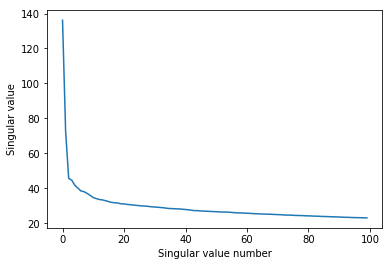

In [10]:
%matplotlib inline
plt.plot(s[::-1])
plt.xlabel("Singular value number")
plt.ylabel("Singular value")
plt.show()

# Number of Topics
Seems reasonable to use anything above 40, and we can increase that number, but make sure to see how that affects the results below for the searches. This is a hyper-parameter we can tune by eye.

In [11]:
total_svd_dt, total_svd_s, total_svd_tt = svds(total_tfidf, k=100)

In [30]:
pickle.dump(total_svd_s, open("data/total_svd_s.pickle", "wb"))
pickle.dump(total_svd_tt, open("data/total_svd_tt.pickle", "wb"))

### Hotel Relation Matrix
Use this matrix if you want to find hotels (Airbnb or TA) that are related to whatever listing you want. Computation takes a while though, beware.

In [12]:
total_svd_ht = np.matmul(total_adj_mat, total_svd_dt)

## Evaluating how SVD does based only on our corpus
Take a look at a couple of queries and the "similar" words based on our corpus. If you don't like the results, adjust the number of topics (k in the svds command above).

In [13]:
word_to_index = total_vectorizer.vocabulary_
index_to_word = {i:t for t,i in word_to_index.iteritems()}
print(total_svd_tt.shape)

(100, 181)


In [14]:
def closest_words(word_in, total_svd_s, total_svd_tt, k = 5):
    if word_in not in word_to_index: return []
    sims = np.matmul(total_svd_tt.T, np.multiply(total_svd_s, total_svd_tt[:, word_to_index[word_in]]))
    asort = np.argsort(-sims)[:k+1]
    return [(index_to_word[i],sims[i]/sims[asort[0]]) for i in asort[1:]]

def pretty_print(q, array_of_tuples):
    print("Word: " + q)
    print("*" * (len(q)+5))
    for (w, sc) in array_of_tuples:
        print(w + ": " + str(sc))
    print("*" * (len(q)+5))
    print()
pretty_print("quiet", closest_words("quiet", total_svd_s, total_svd_tt))
pretty_print("clean", closest_words("clean", total_svd_s, total_svd_tt))
pretty_print("breakfast", closest_words("breakfast", total_svd_s, total_svd_tt))
pretty_print("close", closest_words("close", total_svd_s, total_svd_tt))

Word: quiet
**********
street: 0.112326693964
neighborhood: 0.103048826749
location: 0.0884255282859
apartment: 0.078547692579
clean: 0.0743005567518
**********

Word: clean
**********
apartment: 0.177614360246
towels: 0.17068504298
place: 0.158998282974
bathroom: 0.158126742714
comfortable: 0.146443411221
**********

Word: breakfast
**************
morning: 0.235571983952
free: 0.217817364065
coffee: 0.208403939283
hotel: 0.207153951294
staff: 0.200640522858
**************

Word: close
**********
subway: 0.24197562135
restaurants: 0.126476982962
apartment: 0.118581769555
great: 0.109651252382
place: 0.101985337738
**********



# LDA Search
I've just augmented the query using whatever words ```closest_words``` returns. This is obviously super naive, and gives very high similarity scores because of that, so we can definitely trim this down, but this is just a starting point to work off of.

In [15]:
def print_top_words(mat, feature_names, n_top_words):
    for topic_idx, topic in enumerate(mat):
        print("Rank #%d:" % topic_idx)
        indices = topic.argsort()[:-n_top_words - 1:-1]
        print(" ".join([feature_names[i] for i in indices if topic[i] > 0]))
    print()

In [16]:
ta_tfidf_feature_names = ta_vectorizer.get_feature_names()
airbnb_tfidf_feature_names = airbnb_vectorizer.get_feature_names()
total_tfidf_feature_names = total_vectorizer.get_feature_names()

In [28]:
def search_lda(query, vectorizer, ht_mat, tt_mat, mat_to_listing_dict, svd_weights, svd_topics, top_k = 10):
    query_updated = []
    for q in query.split():
        query_updated += [q]
        query_updated += [w[0] for w in closest_words(q, svd_weights, svd_topics)]
    query_updated = " ".join(query_updated)
    print(query_updated)
    vec = vectorizer.transform([query_updated]).todense().T
    results = np.dot(ht_mat, normalize(np.dot(tt_mat, vec), axis = 0)).T
    indices = np.squeeze(np.asarray(np.argsort(results)))[::-1].T[:top_k]
    scores = np.squeeze(np.asarray(np.sort(results)))[::-1].T[:top_k]    
    listings = np.zeros(indices.shape)
    for i in range(indices.shape[0]):
        listings[i] = mat_to_listing_dict[indices[i]]
    return (listings.tolist(), indices.tolist(), scores.tolist())

In [18]:
listings, indices, scores = search_lda("close", 
                                       airbnb_vectorizer, 
                                       airbnb_lda_ht, 
                                       airbnb_lda_tt, 
                                       airbnb_mat_index_to_listing, 
                                       total_svd_s, 
                                       total_svd_tt)

close subway restaurants apartment great place
(157, 1)


In [19]:
for (l, ind, score) in zip(listings, indices, scores):
    listing_id = str(int(l))
    airbnb_listing_info = airbnb_listings[listing_id]
    print("Listing ID: " + listing_id)
    print("Listing Name: " + airbnb_listing_info['name'])
#     print("Review : \n" + airbnb_reviews[ind])
    print("Listing URL: " + airbnb_listing_info['listing_url'])
    print("Image URL: " + airbnb_listing_info['picture_url'])
    print("Score (Similarity): " + str(score))
    print("**************")

Listing ID: 57874
Listing Name: The Brownstone-Luxury 1 Bd Apt/NYC
Listing URL: https://www.airbnb.com/rooms/57874
Image URL: https://a0.muscache.com/im/pictures/636607/7985819c_original.jpg?aki_policy=large
Score (Similarity): 0.988721721935
**************
Listing ID: 833927
Listing Name: ★ Large Prime Cozy E Village Apt ★
Listing URL: https://www.airbnb.com/rooms/833927
Image URL: https://a0.muscache.com/im/pictures/13031597/eff1db4d_original.jpg?aki_policy=large
Score (Similarity): 0.982292313671
**************
Listing ID: 3190502
Listing Name: Beautiful Upper East Side Apt near Central Park
Listing URL: https://www.airbnb.com/rooms/3190502
Image URL: https://a0.muscache.com/im/pictures/4ff039c3-a9fc-4ee6-b64d-f92bdc34abe4.jpg?aki_policy=large
Score (Similarity): 0.98033266908
**************
Listing ID: 3869779
Listing Name: Loft in Bushwick/East Williamsburg
Listing URL: https://www.airbnb.com/rooms/3869779
Image URL: https://a0.muscache.com/im/pictures/0f8e7c6f-3372-4d17-9d2f-32db

In [20]:
listings, indices, scores = search_lda("neat", 
                                       ta_vectorizer, 
                                       ta_lda_ht, 
                                       ta_lda_tt, 
                                       ta_mat_index_to_listing,
                                       total_svd_s, 
                                       total_svd_tt)

neat
(227, 1)


In [21]:
for (l, ind, score) in zip(listings, indices, scores):
    listing_id = str(int(l))
    
    ta_listing_info = ta_listings[ta_index_to_listing[int(l)]]
#     print("Listing ID: " + listing_id)
    print("Listing Name: " + ta_index_to_listing[int(l)])
#     print("Review : \n" + airbnb_reviews[ind])
    print("Listing URL: " + ta_listing_info[0])
#     print("Image URL: " + airbnb_listing_info['picture_url'])
    print("Score (Similarity): " + str(score))
    print("**************")

Listing Name: Ramada New York/Eastside 
Listing URL: https://www.tripadvisor.com/Hotel_Review-g60763-d99388-Reviews-Ramada_New_York_Eastside-New_York_City_New_York.html
Score (Similarity): 0.0
**************
Listing Name: Morningside Inn 
Listing URL: https://www.tripadvisor.com/Hotel_Review-g60763-d249710-Reviews-Morningside_Inn-New_York_City_New_York.html
Score (Similarity): 0.0
**************
Listing Name: U.S. Pacific Hotel 
Listing URL: https://www.tripadvisor.com/Hotel_Review-g60763-d8722421-Reviews-U_S_Pacific_Hotel-New_York_City_New_York.html
Score (Similarity): 0.0
**************
Listing Name: InterContinental New York Times Square 
Listing URL: https://www.tripadvisor.com/Hotel_Review-g60763-d1646128-Reviews-InterContinental_New_York_Times_Square-New_York_City_New_York.html
Score (Similarity): 0.0
**************
Listing Name: The Roxy Hotel Tribeca 
Listing URL: https://www.tripadvisor.com/Hotel_Review-g60763-d208455-Reviews-The_Roxy_Hotel_Tribeca-New_York_City_New_York.html


In [22]:
listings, indices, scores = search_lda("breakfast", 
                                       total_vectorizer, 
                                       total_lda_ht, 
                                       total_lda_tt, 
                                       total_mat_index_to_listing,
                                       total_svd_s, 
                                       total_svd_tt)

breakfast morning free coffee hotel staff
(181, 1)


In [23]:
threshold = (ta_lda_ht.shape)[0]
for (l, ind, score) in zip(listings, indices, scores):
    if (ind > threshold):
        # Airbnb
        listing_id = str(int(l))
        airbnb_listing_info = airbnb_listings[listing_id]
        print("Listing ID: Airbnb " + listing_id)
        print("Listing Name (Airbnb): " + airbnb_listing_info['name'])
    #     print("Review : \n" + airbnb_reviews[ind])
        print("Listing URL: " + airbnb_listing_info['listing_url'])
        print("Image URL: " + airbnb_listing_info['picture_url'])
        print("Score (Similarity): " + str(score))
        print("**************")
    else:
        # Tripadvisor
        listing_id = str(int(l))

        ta_listing_info = ta_listings[ta_index_to_listing[int(l)]]
        print("Listing ID: Tripadvisor " + listing_id)
        print("Listing Name: " + ta_index_to_listing[int(l)])
    #     print("Review : \n" + airbnb_reviews[ind])
        print("Listing URL: " + ta_listing_info[0])
    #     print("Image URL: " + airbnb_listing_info['picture_url'])
        print("Score (Similarity): " + str(score))
        print("**************")

Listing ID: Tripadvisor 18
Listing Name: Redford Hotel 
Listing URL: https://www.tripadvisor.com/Hotel_Review-g60763-d1583937-Reviews-Redford_Hotel-New_York_City_New_York.html
Score (Similarity): 0.963227262834
**************
Listing ID: Airbnb 6329973
Listing Name (Airbnb): Times Square room with private bath
Listing URL: https://www.airbnb.com/rooms/6329973
Image URL: https://a0.muscache.com/im/pictures/7befc35b-0d27-4669-b72b-2ccbfbe6ecbc.jpg?aki_policy=large
Score (Similarity): 0.952149983175
**************
Listing ID: Airbnb 10902006
Listing Name (Airbnb): Times Square Oasis + Wi-Fi & Sauna
Listing URL: https://www.airbnb.com/rooms/10902006
Image URL: https://a0.muscache.com/im/pictures/5464e928-44af-467f-92c4-c86bd423b4ee.jpg?aki_policy=large
Score (Similarity): 0.942793460458
**************
Listing ID: Airbnb 8033609
Listing Name (Airbnb): Studio Apartment with King Bed
Listing URL: https://www.airbnb.com/rooms/8033609
Image URL: https://a0.muscache.com/im/pictures/c4fd2915-d3b5